#### catatan: 
beberapa data taksonomi memang kosong dari NCBInya, misal data interaksi virus pycv malah terhubung ke genus capsicum bukan spesies capsicum. dan itu memang dari data GloBInya langsung

In [127]:
# # reset import package
# def reloadPackageOwn():
#     from importlib import reload  
#     import os # we use os.path.join, os.path.basename
#     import sys # we use sys.path
#     import glob # we use glob.glob
#     import importlib # we use importlib.import_module

#     import_folder = os.getcwd()
#     sys.path.append(import_folder) # this tells python to look in `import_folder` for imports
#     for src_file in glob.glob(os.path.join(import_folder, '*.py')):
#         name = os.path.basename(src_file)[:-3]
#         importlib.import_module(name)
#         reload(sys.modules[name])
#         importlib.import_module(name)
        
# reloadPackageOwn()

In [128]:
from tqdm import tqdm
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG, Vertex
from pyrdf2vec.embedders import FastText,Word2Vec
from pyrdf2vec.walkers import RandomWalker
from pyvis.network import Network
from sklearn.manifold import TSNE
from umap import UMAP
from SPARQLWrapper import SPARQLWrapper
from jcopml.plot import plot_missing_value

import plotly.express as px
import pandas as pd
import numpy as np
import requests
import os
import networkx as nx
import matplotlib.pyplot as plt

from vectorReferenced import get_taxon_vector,cek_ncbi_id_by_wiki_id
#from process import cek_bfs, nx_to_pyviz

#### Parameter

In [129]:
data=[
    ('Myzus','1cucu','Cucumovirus'),
    ('Bemisia','2cri','Crinivirus'),
    ('Graminella','3wai','Waikavirus'),
    ('Aleyrodidae','begomovirus_22_mei','Begomovirus'),
    ('Schizaphis','5pol','Polerovirus'),
    ('Acyrthosiphon','6pea-nama','Enamovirus'),
    ('Frankliniella','7ort','Orthotospovirus'),
    ('Thrips','8capchlo','Orthotospovirus'),
    ('Laodelphax','9ten','Tenuivirus'),
    ('Sogatella','10fiji','Fijivirus'),
    ('Nilaparvata','+11tung','Tungrovirus'),
    ('Myzus','+12pol','Polerovirus'),
    ('Myzus','+13Poty','Potyvirus'),
]


acuan_,data_,search_=data[3] # vektor acuan  #data virus
bobot_ed=1;
bobot_dc=1;

In [130]:
# link enpoint sparql ncbi_ontology
endpoint_url = 'http://localhost:3030/mydataset/query'

#### input data

In [131]:
#1
#baca data
df_node=pd.read_csv('dari_praproses/'+data_+'_node.csv',index_col=0) 
df_edge=pd.read_csv('dari_praproses/'+data_+'_edge.csv',index_col=0)

In [132]:
#reset cuma karena beberapa data kemarin dpe index blum sempat di reset. kalo diweb tidak pake ini
df_node.reset_index(drop=True,inplace=True)
df_edge.reset_index(drop=True,inplace=True)

In [133]:
#2
#isi data kosong. mengisi takson kosong, dengan takson sebelumnya, untuk tambalan
takson=[
    'superkingdom','kingdom','phylum','class','order','family','genus','species'
]

for x,i in enumerate(takson):
    if (i!='superkingdom'): #selain superkingdom update dengan data sebelumnya
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x-1]]+'^'+i
    else: 
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x+1]]+'^'+i

#### Pengelompokan

In [134]:
# 3
# pengelompokan
# Binning of the data based on serangga, virus, tanaman, nogroup
filter_tanaman = df_node['kingdom']=='NCBI:33090_Viridiplantae' 
filter_virus = (
    (df_node['superkingdom']=='NCBI:10239_Viruses')
    | (df_node.taxon_name.str.contains(r'\b(virus\w*|\w*virus)\b',case=False))
    | (df_node.taxon_path.str.contains(r'\b(virus\w*|\w*virus)\b', case=False)) 
    #jika berawalan atau berakhiran kata virus
)
filter_serangga = ((df_node['class']=='NCBI:50557_Insecta') )#& (df_node['order']!='NCBI:7399_Hymenoptera')) #dan bukan lebah hymenoptera
# df_node['kingdom']=='NCBI:33208_Metazoa' and (df_node['phylum']=='NCBI:6656_Arthropoda' and 
#ini jadi dilema, ada kalau ingin memasukan artropoda lain misal, laba2 maka pake or. untuk saat ini fokus ke insect

df_node.loc[filter_tanaman, ['group','color']] = ["tanaman",'#1f922b'] #hijau
df_node.loc[filter_virus, ['group','color']] = ['virus','#671f92'] #ungu
df_node.loc[filter_serangga, ['group','color']] = ['serangga','#b22222'] #merah
df_node.loc[(
    (filter_tanaman==False) & 
    (filter_virus==False) &
    (filter_serangga==False) 
    ),['group','color']] = ['nogroup','#EADDCA'] #abu-abu

/var/folders/b9/v73gyxys1djbgjy3c8c3cfwm0000gn/T/ipykernel_22424/296316354.py:7: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/b9/v73gyxys1djbgjy3c8c3cfwm0000gn/T/ipykernel_22424/296316354.py:8: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



In [167]:
# cuma tampilan
import plotly.graph_objects as go

data = df_node.groupby(['group','color']).agg({'group': ['count'], }).reset_index().sort_values(
    ('group', 'count'),ascending=False
).reset_index(drop=True).values
labels = [i[0] for i in data]
colors = [i[1] for i in data]
slices = [i[2] for i in data]

fig = go.Figure(data=[go.Pie(labels=labels,values=slices)])
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=20, marker=dict(colors=colors, line=dict(color='#000000', width=0.1)))
fig.show()

In [136]:
slices,labels

([1062, 409, 273, 33], ['virus', 'nogroup', 'tanaman', 'serangga'])

In [137]:
#3
#konversi graph 
gnx = nx.MultiDiGraph()
#node
for i,a in df_node.iterrows():
    #mulai disini akan digunakan taksonomi bahasa indonesia pada data.
    gnx.add_node(
        a['taxon_id'],
        label=a['taxon_name'],
        superkingdom=a['superkingdom'],
        kingdom=a['kingdom'],
        filum=a['phylum'],
        kelas=a['class'],
        ordo=a['order'],
        famili=a['family'],
        genus=a['genus'],
        spesies=a['species'],
        group=a['group'],
        color=a['color'],
    )
#edge
for i,a in df_edge.iterrows():
    gnx.add_edge(
        a['source_taxon_id'],
        a['target_taxon_id'],
        label=a['interaction_type'],
    )

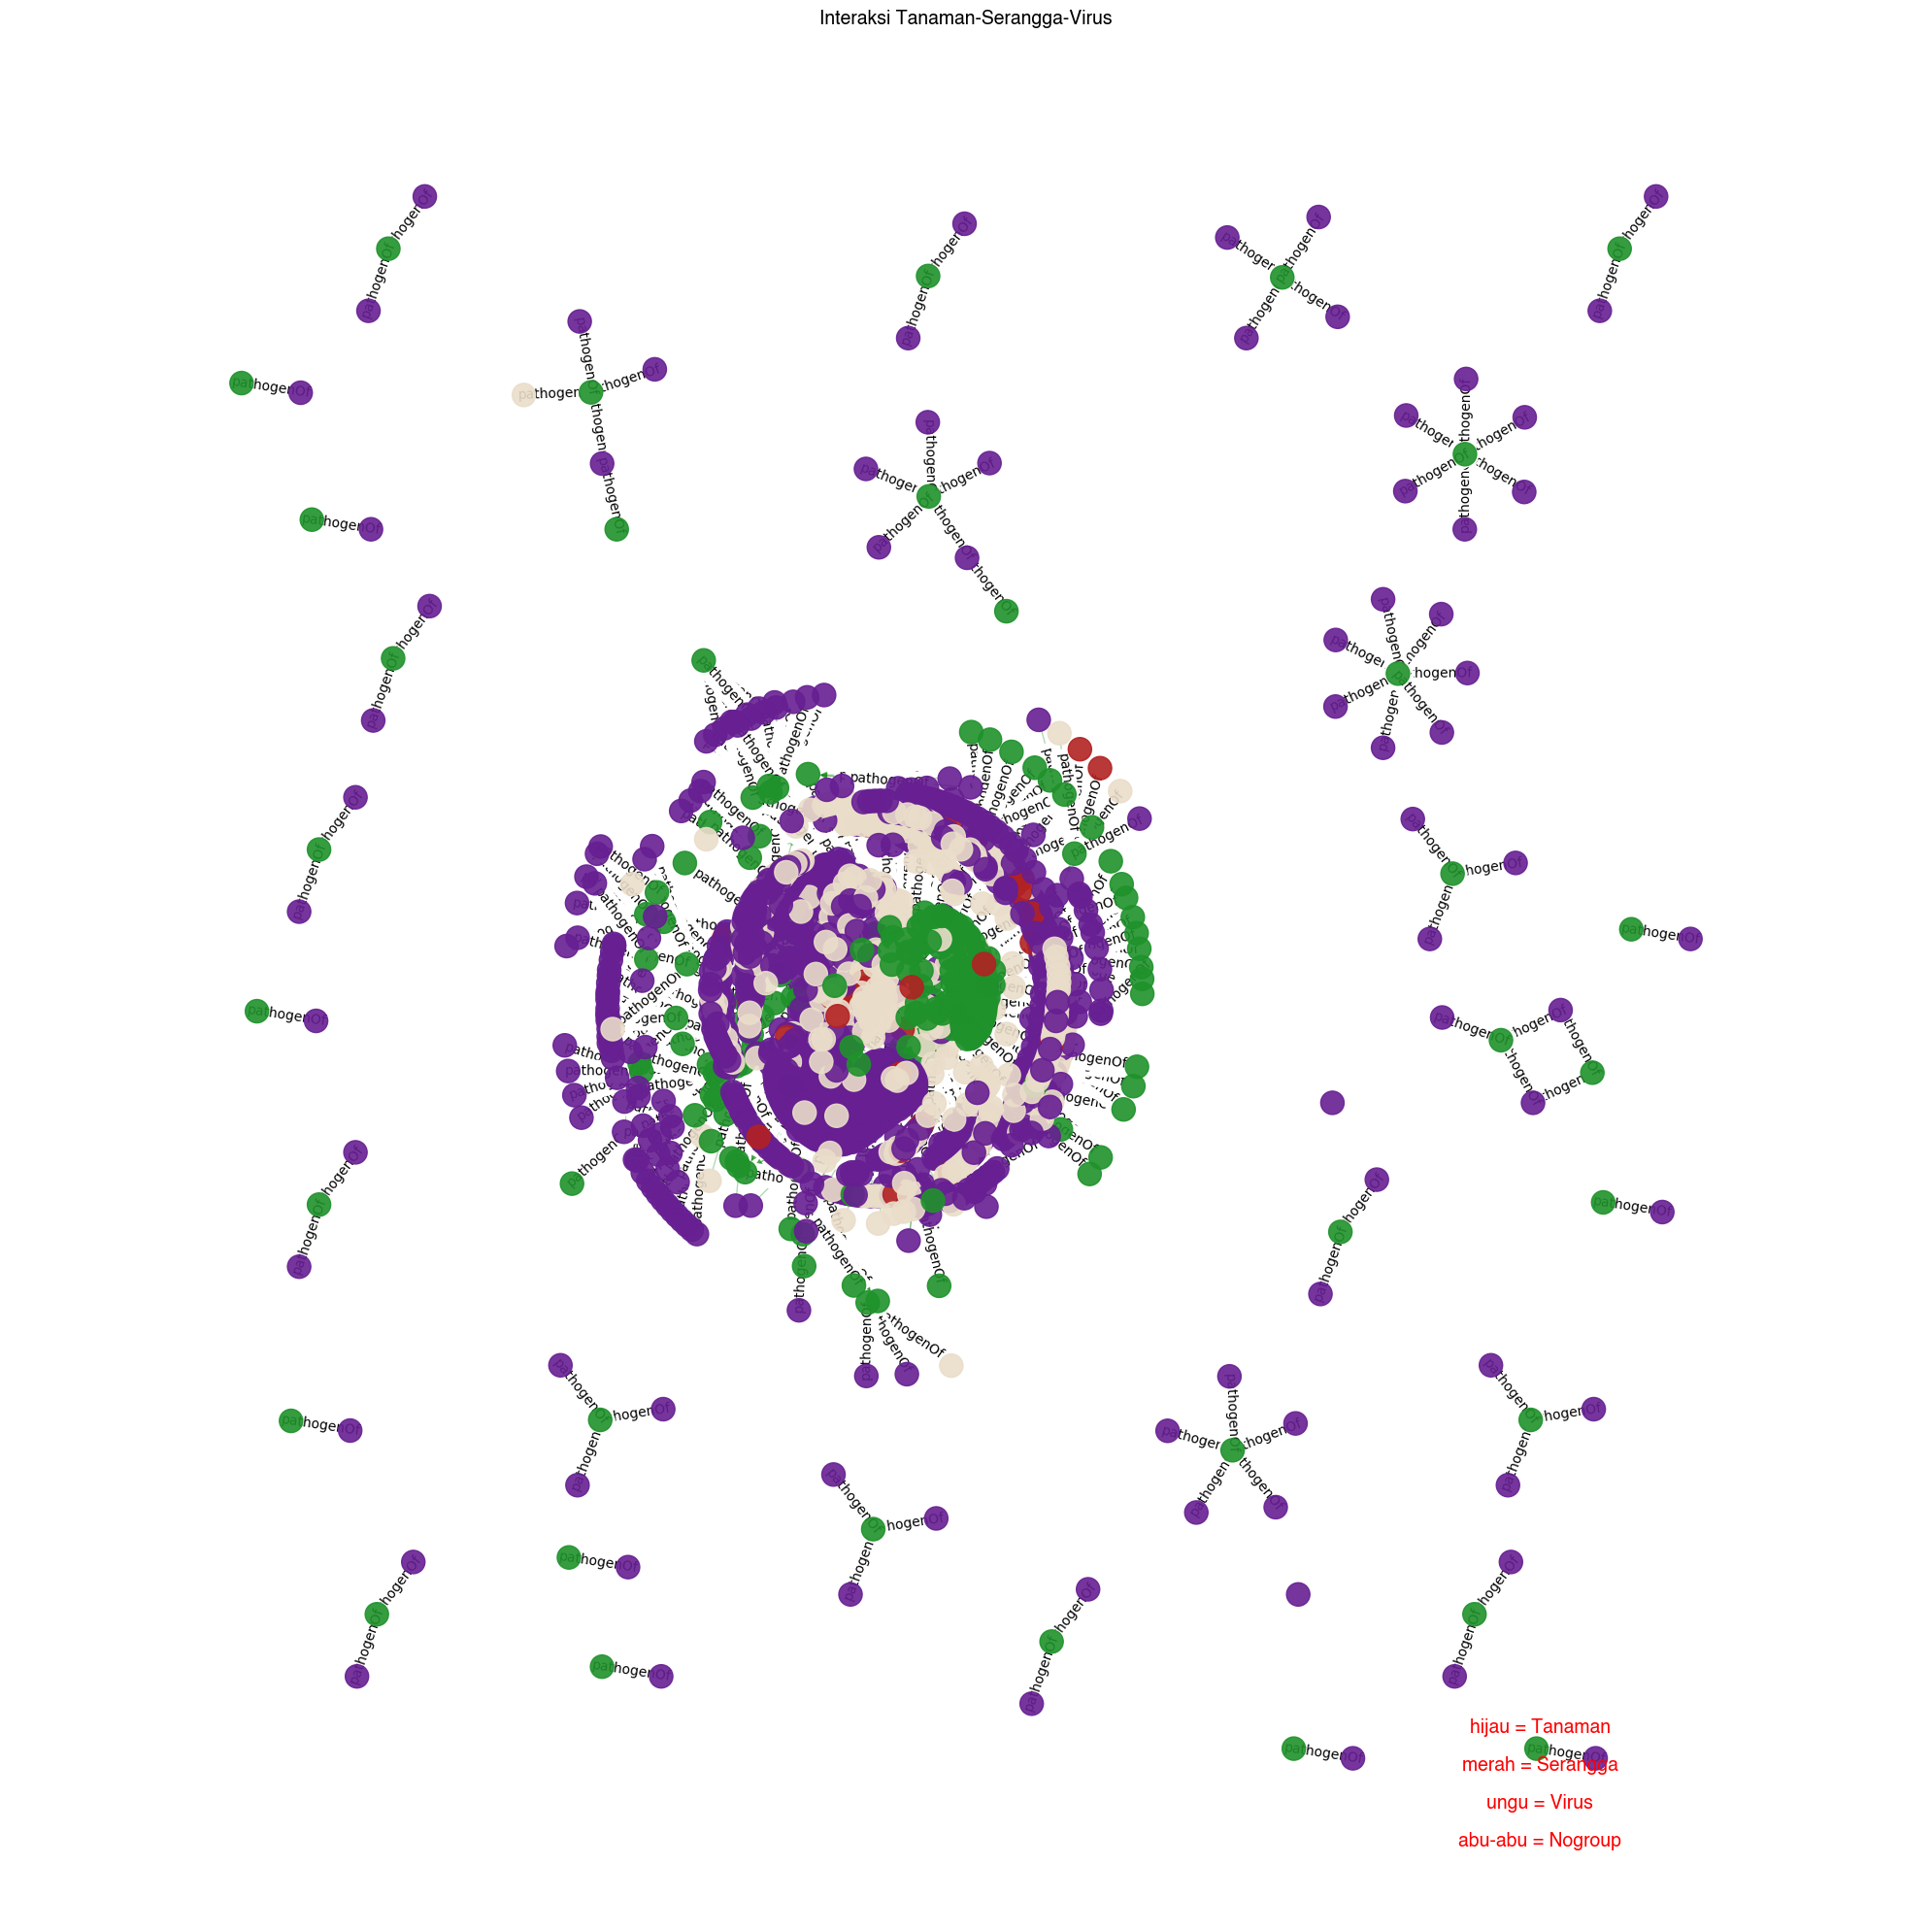

In [138]:
# cuma tampilan, visualisasi graf
G=gnx

fig, ax = plt.subplots(figsize=(20, 20))

# Generate layout for visualization
# pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G, prog="neato", args="")

# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='g')
nx.draw_networkx_nodes(G, pos, node_color=list(nx.get_node_attributes(G, "color").values()), alpha=0.9)

#node label
# for i in ['#b22222','#671f92','#1f922b','#EADDCA']: # filtering dengan bedakan warna node
#     label_options = {"ec": i, "fc": 'white', "alpha": 0.7}
#     nx.draw_networkx_labels(
#         nx.subgraph_view(G, filter_node=lambda n1: G.nodes(data=True)[n1].get("color", True) == i),
#         pos, 
#         font_size=10, 
#         bbox=label_options
#     )

#edge labels
edge_labels={x:i for i,x in zip(nx.get_edge_attributes(G, "label").values(),G.edges())}
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


# Title/legend
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
ax.set_title("Interaksi Tanaman-Serangga-Virus", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "hijau = Tanaman",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.08,
    "merah = Serangga",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.06,
    "ungu = Virus",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.04,
    "abu-abu = Nogroup",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

In [139]:
# cuma tampilan, visualisasi pyviz
from pyvis.network import Network
nt = Network('500px', '900px',directed=True,notebook=True)
# nt.show_buttons(filter_=['physics'])
nt.toggle_physics(True)

for i,data in gnx.nodes(data=True):
    nt.add_node(
        i,
        label= data['label'],
        superkingdom= data['superkingdom'],
        kingdom= data['kingdom'],
        filum= data['filum'],
        kelas= data['kelas'],
        ordo= data['ordo'],
        famili= data['famili'],
        genus= data['genus'],
        spesies= data['spesies'],
        group= data['group'],
        color= data['color'],
        )
    
for s,t,data in gnx.edges(data=True):
    nt.add_edge(
        s,
        t,
        label=data['label'])

# nt.show("tmp.fig02.html")

In [140]:
#4 
# Degree Centrality
results = nx.degree_centrality(gnx)
allnodes = gnx.nodes

In [141]:
# TAMBAHAN UNTUK CEK KUALITAS RELASI SERANGGA
def bfs_relasi_ke_virus_utama(gnx, to_search, virus_utama_ids):
    counter=0
    for edge in nx.bfs_edges(gnx.to_undirected(), source=to_search, depth_limit=2):
        s_id, o_id = edge

        s_label = gnx.nodes[s_id]['label'] +' '+s_id
        o_label = gnx.nodes[o_id]['label'] +' '+o_id

        # skip subjek to_search
        if (s_id == to_search) & (o_id in virus_utama_ids):
            print(s_label,'-->', o_label)
            counter+=1
    
    return counter

# tandai virus utama
search_virus,taxon_,ncbi_id_=cek_ncbi_id_by_wiki_id(search_)
print("keyword virus utama: ",(search_virus,taxon_,ncbi_id_))
df_node.loc[df_node[taxon_].str.contains(search_virus), ['virus_utama']] = True

# hitung relasi ke virus utama setiap serangga
virus_utama_ids=list(df_node[df_node['virus_utama']==True].taxon_id)
for idx,data in df_node[(df_node['group']=='serangga')].iterrows():
    print(idx,data.taxon_name,data.taxon_id)
    _relasi = bfs_relasi_ke_virus_utama(gnx,data.taxon_id,virus_utama_ids)
    print(_relasi)
    df_node.loc[idx,'relasi_ke_virus_utama'] = _relasi
    print("=================")
    # update DC pake bobot
    reset_n=(len(gnx.nodes)-1)/(len([node for node, data in gnx.nodes(data=True) if data.get('group') == "serangga"])-1)
    results[data.taxon_id] = 1+(results[data.taxon_id]*_relasi*reset_n) #1+(CM*w)
    # results[data.taxon_id] = 1+(results[data.taxon_id]*_relasi) #1+(CM*w)

keyword virus utama:  ('Begomovirus', 'genus', 'NCBI:10814')
19 Aleyrodoidea NCBI:33377
Aleyrodoidea NCBI:33377 --> Whitefly VEM 1 begomovirus NCBI:1032481
Aleyrodoidea NCBI:33377 --> Whitefly VEM 2 begomovirus NCBI:1032482
2
20 Aleyrodidae NCBI:7036
Aleyrodidae NCBI:7036 --> Whitefly VEM 1 begomovirus NCBI:1032481
Aleyrodidae NCBI:7036 --> Whitefly VEM 2 begomovirus NCBI:1032482
2
293 Spodoptera litura NCBI:69820
0
294 Spodoptera littoralis NCBI:7109
0
387 Thaumatotibia leucotreta NCBI:7139
0
388 Chlorophorus annularis NCBI:2586298
0
400 Conogethes punctiferalis NCBI:1133088
0
401 Pectinophora gossypiella NCBI:13191
0
403 Oxycarenus hyalinipennis NCBI:1149918
0
404 Autographa gamma NCBI:254363
0
405 Anthonomus grandis NCBI:7043
0
409 Helicoverpa armigera NCBI:29058
0
410 Amrasca biguttula NCBI:30102
0
411 Adelphocoris NCBI:236345
0
412 Lygus NCBI:30084
0
510 Peru NCBI:1634180
0
529 Heteronemia NCBI:629302
0
618 Crocidosema aporema NCBI:581467
0
622 Chrysodeixis chalcites NCBI:749652
0

In [142]:
dc_serangga=[]
for node_id, rank in sorted(results.items(), key=lambda item: item[1], reverse=True):
    if allnodes[node_id]['group'] in ['serangga']:
        label = gnx.nodes[node_id]['label']
        dc_serangga.append((rank, label, node_id))

In [143]:
dc_serangga

[(9.9375, 'Aleyrodidae', 'NCBI:7036'),
 (9.25, 'Aleyrodoidea', 'NCBI:33377'),
 (3.5625, 'Bemisia tabaci', 'NCBI:7038'),
 (1.0, 'Spodoptera litura', 'NCBI:69820'),
 (1.0, 'Spodoptera littoralis', 'NCBI:7109'),
 (1.0, 'Thaumatotibia leucotreta', 'NCBI:7139'),
 (1.0, 'Chlorophorus annularis', 'NCBI:2586298'),
 (1.0, 'Conogethes punctiferalis', 'NCBI:1133088'),
 (1.0, 'Pectinophora gossypiella', 'NCBI:13191'),
 (1.0, 'Oxycarenus hyalinipennis', 'NCBI:1149918'),
 (1.0, 'Autographa gamma', 'NCBI:254363'),
 (1.0, 'Anthonomus grandis', 'NCBI:7043'),
 (1.0, 'Helicoverpa armigera', 'NCBI:29058'),
 (1.0, 'Amrasca biguttula', 'NCBI:30102'),
 (1.0, 'Adelphocoris', 'NCBI:236345'),
 (1.0, 'Lygus', 'NCBI:30084'),
 (1.0, 'Peru', 'NCBI:1634180'),
 (1.0, 'Heteronemia', 'NCBI:629302'),
 (1.0, 'Crocidosema aporema', 'NCBI:581467'),
 (1.0, 'Chrysodeixis chalcites', 'NCBI:749652'),
 (1.0, 'Diabrotica speciosa', 'NCBI:133126'),
 (1.0, 'Macrosiphum euphorbiae', 'NCBI:13131'),
 (1.0, 'Myzus persicae', 'NCBI:131

In [164]:
#visualisasi data
# mengecek BFS Degree tertinggi
for to_search  in ["NCBI:7038"]:#"NCBI:33377","NCBI:7036",
    for edge in nx.bfs_edges(gnx.to_undirected(), source=to_search, depth_limit=1):
            s_id, o_id = edge

            s_label = gnx.nodes[s_id]['label'] +' '+s_id
            o_label = gnx.nodes[o_id]['label'] +' '+o_id
            o_grup = gnx.nodes[o_id]['group']

            # skip subjek to_search
            if (o_grup == 'tanaman'):
                print(s_label,'-->', o_label)
    print('===============')

Bemisia tabaci NCBI:7038 --> Melissa officinalis NCBI:39338
Bemisia tabaci NCBI:7038 --> Euphorbia cyathophora NCBI:216473
Bemisia tabaci NCBI:7038 --> Euphorbia heterophylla NCBI:212910
Bemisia tabaci NCBI:7038 --> Euphorbia characias NCBI:3991
Bemisia tabaci NCBI:7038 --> Ipomoea nil NCBI:35883
Bemisia tabaci NCBI:7038 --> Datura wrightii NCBI:434267
Bemisia tabaci NCBI:7038 --> Hibiscus moscheutos NCBI:241598
Bemisia tabaci NCBI:7038 --> Pentas lanceolata NCBI:25385
Bemisia tabaci NCBI:7038 --> Hypoestes phyllostachya NCBI:101678
Bemisia tabaci NCBI:7038 --> Caryopteris divaricata NCBI:41385
Bemisia tabaci NCBI:7038 --> Laggera pterodonta NCBI:313966
Bemisia tabaci NCBI:7038 --> Parthenium hysterophorus NCBI:183063
Bemisia tabaci NCBI:7038 --> Bauhinia tomentosa NCBI:204518
Bemisia tabaci NCBI:7038 --> Mesona chinensis NCBI:4136
Bemisia tabaci NCBI:7038 --> Mucuna pruriens NCBI:157652
Bemisia tabaci NCBI:7038 --> Cyamopsis tetragonoloba NCBI:3831
Bemisia tabaci NCBI:7038 --> Humulus

In [146]:
for i in ["NCBI:33377","NCBI:7036","NCBI:7038","NCBI:65032"]:
    print(gnx.nodes[i])

{'label': 'Aleyrodoidea', 'superkingdom': 'NCBI:2759_Eukaryota', 'kingdom': 'NCBI:33208_Metazoa', 'filum': 'NCBI:6656_Arthropoda', 'kelas': 'NCBI:50557_Insecta', 'ordo': 'NCBI:7524_Hemiptera', 'famili': 'NCBI:7524_Hemiptera^family', 'genus': 'NCBI:7524_Hemiptera^family^genus', 'spesies': 'NCBI:7524_Hemiptera^family^genus^species', 'group': 'serangga', 'color': '#b22222'}
{'label': 'Aleyrodidae', 'superkingdom': 'NCBI:2759_Eukaryota', 'kingdom': 'NCBI:33208_Metazoa', 'filum': 'NCBI:6656_Arthropoda', 'kelas': 'NCBI:50557_Insecta', 'ordo': 'NCBI:7524_Hemiptera', 'famili': 'NCBI:7036_Aleyrodidae', 'genus': 'NCBI:7036_Aleyrodidae^genus', 'spesies': 'NCBI:7036_Aleyrodidae^genus^species', 'group': 'serangga', 'color': '#b22222'}
{'label': 'Bemisia tabaci', 'superkingdom': 'NCBI:2759_Eukaryota', 'kingdom': 'NCBI:33208_Metazoa', 'filum': 'NCBI:6656_Arthropoda', 'kelas': 'NCBI:50557_Insecta', 'ordo': 'NCBI:7524_Hemiptera', 'famili': 'NCBI:7036_Aleyrodidae', 'genus': 'NCBI:7037_Bemisia', 'spesies

In [147]:
# pake wikidata

In [148]:
#5
# Ambil data NCBI
# data acuan
data_acuan=get_taxon_vector(acuan_,endpoint_url)
data_acuan

[('famili', 'NCBI:7036_Aleyrodidae'),
 ('ordo', 'NCBI:7524_Hemiptera'),
 ('kelas', 'NCBI:50557_Insecta'),
 ('filum', 'NCBI:6656_Arthropoda'),
 ('kingdom', 'NCBI:33208_Metazoa'),
 ('superkingdom', 'NCBI:2759_Eukaryota')]

In [149]:
for i in ['Myzus persicae',
    'Bemisia Tabaci',
    'Graminella nigrifrons',
    'Bemisia Tabaci',
    'Schizaphis graminum',
    'Myzus Persicae',
    'Frankliniella occidentalis',
    'Myzus Persicae',
    'Laodelphax striatellus',
    'Sogatella furcifera']:
    print(get_taxon_vector(i,endpoint_url))

[('spesies', 'NCBI:13164_Myzus persicae'), ('genus', 'NCBI:13163_Myzus'), ('famili', 'NCBI:27482_Aphididae'), ('ordo', 'NCBI:7524_Hemiptera'), ('kelas', 'NCBI:50557_Insecta'), ('filum', 'NCBI:6656_Arthropoda'), ('kingdom', 'NCBI:33208_Metazoa'), ('superkingdom', 'NCBI:2759_Eukaryota')]
[('spesies', 'NCBI:7038_Bemisia tabaci'), ('genus', 'NCBI:7037_Bemisia'), ('famili', 'NCBI:7036_Aleyrodidae'), ('ordo', 'NCBI:7524_Hemiptera'), ('kelas', 'NCBI:50557_Insecta'), ('filum', 'NCBI:6656_Arthropoda'), ('kingdom', 'NCBI:33208_Metazoa'), ('superkingdom', 'NCBI:2759_Eukaryota')]
[('spesies', 'NCBI:30127_Graminella nigrifrons'), ('genus', 'NCBI:30125_Graminella <bugs>'), ('famili', 'NCBI:30102_Cicadellidae'), ('ordo', 'NCBI:7524_Hemiptera'), ('kelas', 'NCBI:50557_Insecta'), ('filum', 'NCBI:6656_Arthropoda'), ('kingdom', 'NCBI:33208_Metazoa'), ('superkingdom', 'NCBI:2759_Eukaryota')]
[('spesies', 'NCBI:7038_Bemisia tabaci'), ('genus', 'NCBI:7037_Bemisia'), ('famili', 'NCBI:7036_Aleyrodidae'), ('ord

In [150]:
#6
#konversi node networkx ke RDF
URL = "http://pyRDF2Vec"
CUSTOM_KG = KG()

takson=[i[0] for i in data_acuan]
for i in ["superkingdom","kingdom","filum","kelas"]:
    takson.remove(i) 

# memasukan RDF serangga acuan
subj = Vertex(f"{URL}#SERANGGA_ACUAN")
for i,j in data_acuan:
    if(i not in ["superkingdom","kingdom","filum","kelas"]):
        j = j.replace(' ','-')
        obj = Vertex((URL+"#"+j))
        pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
        #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
        CUSTOM_KG.add_walk(subj, pred, obj)

# proses konversi 
for index,data in gnx.nodes(data=True):
    if(data['group']=='serangga'): #jika serangga
        subj = Vertex(URL+"#"+index)
        for i in takson:
            #if(isinstance(data[i], str)): #jika dia string atau tidak nan/kosong.
            #if(i not in ["superkingdom","kingdom","filum","kelas"]):
                id_takson=data[i].replace(' ','-')#.split('_')[0]
                obj = Vertex((URL+"#"+id_takson))
                pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
                #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
                CUSTOM_KG.add_walk(subj, pred, obj)
# CUSTOM_KG.literals=[
#         [f"{URL}#taxon_path_ids"],
#     ]
CUSTOM_KG.literals = [[URL+"#"+i] for i in takson]

In [151]:
#7
#embedding
# Ensure the determinism of this script by initializing a pseudo-random number.
RANDOM_STATE = 22
transformer = RDF2VecTransformer(
    # Use one worker threads for Word2Vec to ensure random determinism.
    # Must be used with PYTHONHASHSEED.
    Word2Vec(epochs=1000),
    # Extract a maximum of 10 walks of a maximum depth of 4 for each entity
    # using two processes and use a random state to ensure that the same walks
    # are generated for the entities.
    walkers=[RandomWalker(2, 5, n_jobs=2, with_reverse=False, random_state=RANDOM_STATE)],
    #verbose=1,
)
# transformer = RDF2VecTransformer(verbose=1)
# list entity yang akan diembedd. serangga acuan urutan terakhir
ent = [ URL+"#"+index for index,data in gnx.nodes(data=True) if(data['group']=='serangga') ] #jika serangga
ent.append(f"{URL}#SERANGGA_ACUAN")
# Fit the transformer to the knowledge graph and the entities.
embeddings, _ = transformer.fit_transform(
    CUSTOM_KG, #the KG
    ent, #entity
)

In [152]:
# visualisasi

# Reduce the dimensions of entity embeddings to represent them in a 2D plane.
X= UMAP().fit_transform(embeddings)
df_umap=pd.DataFrame(X,columns=['feature-vector-1','feature-vector-2'])


text=[]
labels=[]
for x in transformer._entities:
    if(x!="http://pyRDF2Vec#SERANGGA_ACUAN"):
        text.append(gnx.nodes[x.split("#")[-1]]['famili'].split('_')[-1])
        labels.append(gnx.nodes[x.split("#")[-1]]['label'])
    else:
        text.append("#TITIK_VEKTOR_ACUAN")
        labels.append("#TITIK_VEKTOR_ACUAN")
df_umap['text']=text
df_umap['labels']=labels

# # gnx.nodes[x.split("#")[-1]]['label']
# df_umap['text']=list(map(lambda x: x.split("#")[-1],transformer._entities))
fig = px.scatter(df_umap, x='feature-vector-1',y='feature-vector-2',text='text',hover_name='labels')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=650,
    title_text='reduced word2vec visualization'
)
fig.show()

In [153]:
#8
#euclidean distance

# buat dataframe
data_to_count=pd.DataFrame(embeddings, columns=list(range(0,100)))

# buat kolom label
ent=[data['label'] for index,data in gnx.nodes(data=True) if(data['group']=='serangga')] #jika serangga
ent.append("#SERANGGA_ACUAN")
data_to_count['label']=ent

#buat kolom entity
data_to_count['entity']=[i.replace("http://pyRDF2Vec#","") for i in transformer._entities]

# buat kolom hasil dc
for idx,row in data_to_count.iterrows(): #jika serangga acuan maka DC di isi nilai 1
    data_to_count.loc[idx,['dc_result']] = results[row['entity']] if(row['entity']!="SERANGGA_ACUAN") else 1

#ambil koordinat acuan
acuan=next(data_to_count[data_to_count['label']=='#SERANGGA_ACUAN'].iterrows())[1]
acuan=np.array(tuple(acuan[i] for i in range(0,100)))
acuan

#hitung ED
for idx, row in data_to_count.iterrows():
    temp = np.array(tuple(row[i] for i in range(0,100)))
    data_to_count.loc[idx,['ed_result']] = np.linalg.norm(temp - acuan)

#drop data acuan
data_to_count.drop(data_to_count[data_to_count.label=="#SERANGGA_ACUAN"].index,inplace=True)

# minmax scaling dc dan ed
from sklearn.preprocessing import MinMaxScaler
for i in ['dc_result', 'ed_result']:
    scaler = MinMaxScaler()
    scaler.fit(data_to_count[i].to_numpy().reshape(1, -1))
    scaler.transform(data_to_count[i].to_numpy().reshape(1, -1))

In [154]:
#drop kolom embedding
data_to_count.drop(columns=list(range(0,100)), inplace=True)

In [155]:
#9
#hitung kombinasi
for idx, row in data_to_count.iterrows():
    _dc = row['dc_result']
    _ed=( (row['ed_result']) if row['ed_result']!=0 else 1)
    data_to_count.loc[idx,['result']] = _dc/_ed
    
# urutkan
data_to_count=data_to_count.sort_values('result',ascending=False).reset_index(drop=True)
data_to_count[['label','dc_result','ed_result','result']]

,label,dc_result,ed_result,result
0,Aleyrodidae,9.9375,0.089365,111.201811
1,Bemisia tabaci,3.5625,0.095107,37.457640
2,Aleyrodoidea,9.2500,0.438615,21.089107
3,Macrosiphum euphorbiae,1.0000,0.218600,4.574563
4,Tecia solanivora,1.0000,0.228275,4.380683
5,Myzus persicae,1.0000,0.228393,4.378420
6,Adelphocoris,1.0000,0.229998,4.347858
7,Lygus,1.0000,0.247130,4.046451
8,Conogethes punctiferalis,1.0000,0.251139,3.981852
9,Thaumatotibia leucotreta,1.0000,0.256233,3.902703


In [156]:
# df_node[df_node.taxon_id.isin(['NCBI:7036',
# 'NCBI:33377',
# 'NCBI:7038',
# 'NCBI:1634180',
# 'NCBI:137042',
# 'NCBI:253718',])]

# Hemiptera
# Aleyrodidae

# Orthoptera
# Phalangopsidae
# Peru


# Hymenoptera
# Crabronidae
# Lithium




In [157]:
data_to_count[['label','dc_result']].sort_values('dc_result',ascending=False).reset_index(drop=True)

,label,dc_result
0,Aleyrodidae,9.9375
1,Aleyrodoidea,9.2500
2,Bemisia tabaci,3.5625
3,Lithium,1.0000
4,Bactrocera zonata,1.0000
5,Peru,1.0000
6,Diabrotica speciosa,1.0000
7,Anthonomus grandis,1.0000
8,Helicoverpa armigera,1.0000
9,Heteronychus arator,1.0000


In [158]:
data_to_count[['label','entity','ed_result']].sort_values('ed_result',ascending=True).reset_index(drop=True)

,label,entity,ed_result
0,Aleyrodidae,NCBI:7036,0.089365
1,Bemisia tabaci,NCBI:7038,0.095107
2,Macrosiphum euphorbiae,NCBI:13131,0.218600
3,Tecia solanivora,NCBI:396680,0.228275
4,Myzus persicae,NCBI:13164,0.228393
5,Adelphocoris,NCBI:236345,0.229998
6,Lygus,NCBI:30084,0.247130
7,Conogethes punctiferalis,NCBI:1133088,0.251139
8,Thaumatotibia leucotreta,NCBI:7139,0.256233
9,Epiphyas postvittana,NCBI:65032,0.257908


# Pengujian

In [159]:
id_hasil=data_to_count.iloc[0].entity
cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
cek_acuan= { k:v for k,v in data_acuan if k in takson }

print(acuan_,'->', data_)
print('acuan ',cek_acuan)
print('hasil ',cek_hasil)

cek=0
for i in reversed(takson):
    cekk=cek_hasil[i]==cek_acuan[i]
    cek+=cekk
    print(i, cekk)


print(cek/len(takson))

Aleyrodidae -> begomovirus_22_mei
acuan  {'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
hasil  {'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
ordo True
famili True
1.0


In [160]:
df_node[df_node['order'].str.contains('7399_Hymenoptera')]

,taxon_id,taxon_name,taxon_path,taxon_path_ids,taxon_path_rank,taxon_rank,superkingdom,kingdom,phylum,class,order,family,genus,species,group,color,virus_utama,relasi_ke_virus_utama
1605,NCBI:253718,Lithium,Animalia | Arthropoda | Insecta | Hymenoptera ...,GBIF:1 | NCBI:6656 | NCBI:50557 | NCBI:7399 | ...,kingdom | phylum | class | order | family | genus,family,NCBI:2759_Eukaryota,NCBI:33208_Metazoa,NCBI:6656_Arthropoda,NCBI:50557_Insecta,NCBI:7399_Hymenoptera,NCBI:253718_Crabronidae,GBIF:4298312_Lithium,GBIF:4298312_Lithium^species,serangga,#b22222,NaN,0.0


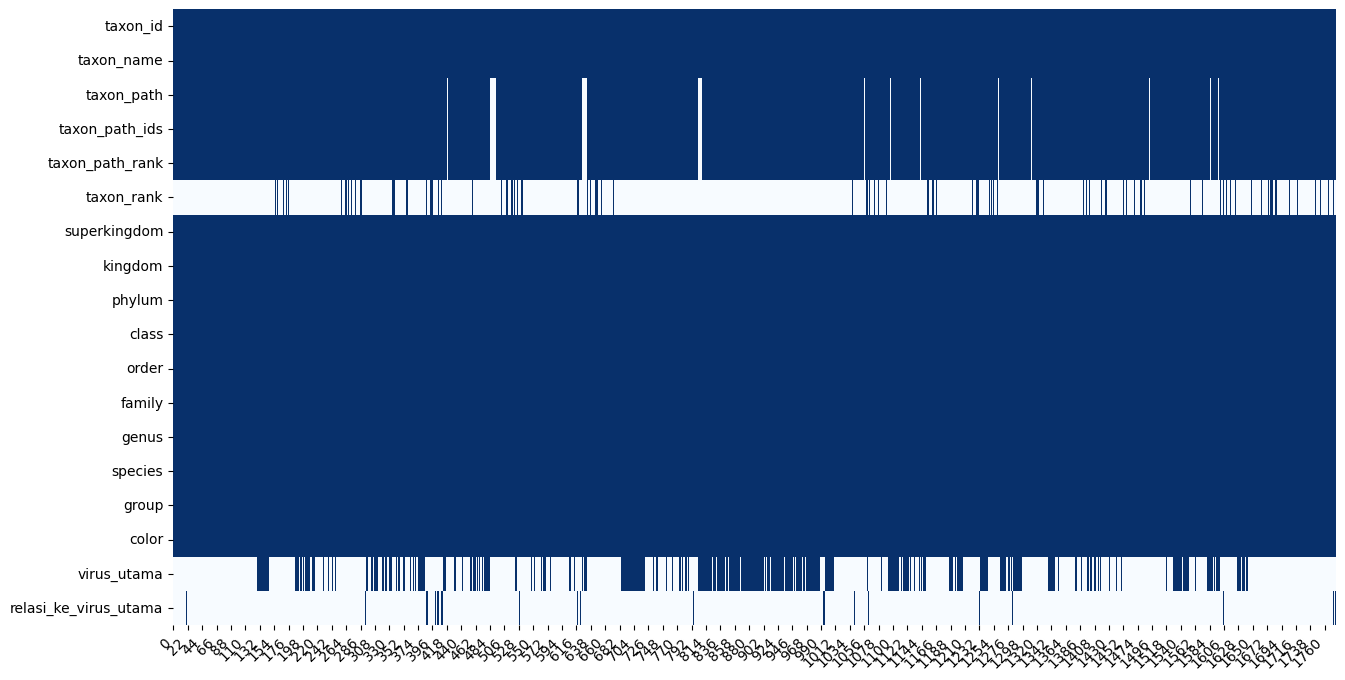

In [161]:
plot_missing_value(df_node)